# Quantum Phase Estimation Algorithm
## Matvei Karp
06/25/2025

## Imports

### Importing Qiskit

Qiskit Itself

In [1]:
from qiskit import *

Visualisations

In [2]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram

Simulators

In [3]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

### Importing Other Useful Libraries

Random

*Python's random number package*

In [4]:
import random as r

Numpy

*Python's scientific computing package*

In [5]:
import numpy as np

From Qiskit:
*Numpy Matrix to Qiskit Gate*

In [6]:
from qiskit.circuit.library import UnitaryGate

## Display Functions

### Histogram

executes the circuit in an ideal environment 1024 times and returns the results as a histogram

    Parameters
    ----------
    circuit: QuantumCircuit
        The circuit to be executed
    Returns
    -------
    None

In [7]:
def histogram(circuit):
    circ = circuit.copy()
    aersim = AerSimulator()
    circTranspiled = transpile(circ,aersim)
    result_ideal = aersim.run(circTranspiled, shots=1024).result()
    counts_ideal = result_ideal.get_counts(0)
    return counts_ideal

## The Problem

Given a Unitary Matrix $U$, find its eigenvalues (and through that its eigenvectors).

### Some Background

An eigenvector is a vector which is not rotated when a matrix is applied to it, and is only extended by a factor (this factor is its corresponding eigenvalue $\lambda$). It is trivial to classically find the eigenvector that corresponds to a known eigenvalue, as that is just a system of equations:


$$\begin{bmatrix}
a & b \\
c & d \\
\end{bmatrix} \begin{bmatrix}
v_1 \\
v_2
\end{bmatrix} = \begin{bmatrix}
\lambda v_1 \\
\lambda v_2
\end{bmatrix} $$

$$\begin{equation}
\left\{ \begin{aligned} 
  av_1+bv_2 &= \lambda v_1\\
  cv_1+dv_2 &= \lambda v_2
\end{aligned} \right.
\end{equation}$$

Since the vectors we deal with are quantum states, we will also use the term eigenstate.

What is not trivial, however, is finding the eigenvalues in the first place. The classical approach rapidly becomes very difficult, as it relies upon the characteristic polynomial.
For matrix $A$ the characteristic polynomial is:

$$det(A-\lambda I) = det(A - \begin{bmatrix}
\lambda & 0 & ... & 0 \\
0 & \lambda & ... & 0 \\
... & ... & ... & ... \\
0 & 0 & ... & \lambda
\end{bmatrix})$$

Where $I$ is the identity matrix.

The eigenvalues are the roots of this polynomial. While this seems easy with a 3x3 matrix when the highest power is 3, a 100x100 matrix is very hard to deal with.

Luckily, if we are dealing with unitary matrices, we have a way out for several reasons:

1. Unitary matrices are valid quantum gates, so they can be directly implemented as sequences of gates
2. The eigenvalues of unitary matrices have several special properties, those being that they form an orthonormal basis.

### Solution Format

Since the eigenvalue is a complex value with an absolute value of 1, we can represent it using Euler's formula:

$$ cos(\phi)+i*sin( \phi)=e^{i \phi} $$

Thus:

$$ \lambda = e^{i \phi} $$

$ \phi $ is the eigenphase. Unfortunately, it has a period of $2 \pi$. Luckily, we can simply remove a factor of $2 \pi$:

$$ \lambda = e^{2 \pi i \theta} $$

The Quantum Phase Algorithm will return this $\theta$ as a binary fraction, as the maximum value is 1.

Binary fractions are the binary equivalent to a decimal fraction:

$$0.0101_{base 2} = 0.3125_{base 10}$$

The algorithm will output this as a state such as $0101$ for the previous example. The precision will thus be limited by the number of qubits in the main register.

## Deriving the Algorithm

Initially, we will assume that the second register has the corresponding eigenstate $\ket{\psi}$ to the eigenvalue we are searching for. This will change near the end of this derivation.

This means that the transformation we need to accomplish is as follows:

$$\ket{0} \otimes \ket{\psi} \rightarrow \ket{\theta} \otimes \ket{\psi} $$

It is not immediately obvious what to do, so we can try one of the most useful transformations we have, the Quantum Fourier Transform:

$$ QFT\ket{\theta} = \frac{1}{2^n}\sum_{k=0}^{2^n}e^{2\pi i \theta k}\ket{k} $$

This reveals that if we had this equal superposition, we could get to our output with an inverse QFT.

Now our objective is to get to this state. Here we remember an important detail:
Since $\ket{\psi}$ is an eigenstate:

$$U\ket{\psi} = e^{2\pi i \theta} \ket{\psi} $$

If this is repeated $k$ times:

$$U^k\ket{\psi} = e^{2\pi i \theta k} \ket{\psi} $$

Per the properties of the kronecker product:
$$\ket{a} \otimes U^k\ket{\psi} = e^{2\pi i \theta k} \ket{a} \otimes \ket{\psi} $$

Thus the only thing we must do is to achieve the summation.

Using the Hadamard gate, we can trivially create an equal superposition:

$$\ket{0} \rightarrow \frac{1}{2^n}\sum_{k=0}^{2^n}\ket{k} $$

We then have to vary the number of $U$ gates we apply in accordance with the value of $k$, which is the value of the main register.

For example, take the case when $k = 7$:

The main register holds the state $1,1,1$, which is read in binary as $4,2,1$.

We need to apply $U$ $4$ times for first qubit, $2$ times for the second qubit, and $1$ time for the last qubit.

If the value of $k$ were $6$ ($1,1,0$), the same would need to be done but the last qubit will not have an effect.

This is implemented trivially with a series of controlled $U$ gates.

Specifically, since each qubit has the binary value of $2^{p}$ where $p$ is its index number (counting down to 0), each qubit in the main register controls $p$ $U$ gates targetting the second register. 

#### The Diagram

Combining all these steps:
1. Set up 2 registers, one of which contains an eigenstate of $U$
2. Apply Hadamard gates to all qubits in the main register
3. Apply a series of controlled $U$ gates
4. Apply the inverse QFT to the main register
5. Measure the main register

![Circuit Image](QPE.png)

#### A Final Note

Up until now we have been dealing with the case where the second register contains the corresponding eigenstate. This is not actually necessary, and we will simply initiate the state as $\ket{0}$, as the eigenstates of unitary gates form a basis, so any other state is just a combination of eigenstates and will lead to the algorithm returning one of the eigenvalues, or, with enough iterations, all of them.

## Main Workspace

### 1. Setting up the registers
    In this example, we will use a 4 qubit main register and a 2 qubit register for the state.

In [8]:
m = 4
n = 2
main = QuantumRegister(m, "main")  
state = QuantumRegister(n,"state")
output = ClassicalRegister(m, "output")
circuit = QuantumCircuit(main, state, output)

### 2. The Hadamard Gates
    We now put the main register into an equal superposition of all possible states

In [9]:
circuit.h(main)

### 3. The controlled unitary sequence
    We now apply our unitary matrix, such that qubit n controls 2^{n} gates on the state register

In [10]:
Xgate = np.array([[0,1],[1,0]])
Zgate = np.array([[1,0],[0,-1]])
customUnitary = np.kron(Xgate,Zgate)
print(customUnitary)
ControlledCustomGate = UnitaryGate(customUnitary).control(1)

[[ 0  0  1  0]
 [ 0  0  0 -1]
 [ 1  0  0  0]
 [ 0 -1  0  0]]


In [11]:
for i in range(m):
    counter = 0
    while counter < 2**i:
        circuit.append(ControlledCustomGate, [main[i],state[0],state[1]])
        counter+=1

### 4. The Inverse Quantum Fourier Transform
    Now we apply the inverse Quantum Fourier Transform on the main register

In [12]:
for i in range(m):
    j = m-i-1
    circuit.h(j)
    for k in range(j):
        l = j-k
        circuit.cp(np.pi/(2**k),main[j],main[l-1])
for i in range(m//2):
    circuit.swap(main[i],main[m-i-1])

### 5. Measure
    We now measure the main register (and discard the state register)

In [13]:
circuit.measure(main,output)

### 6. Visualisation
    We can now look at the circuit we have constructed

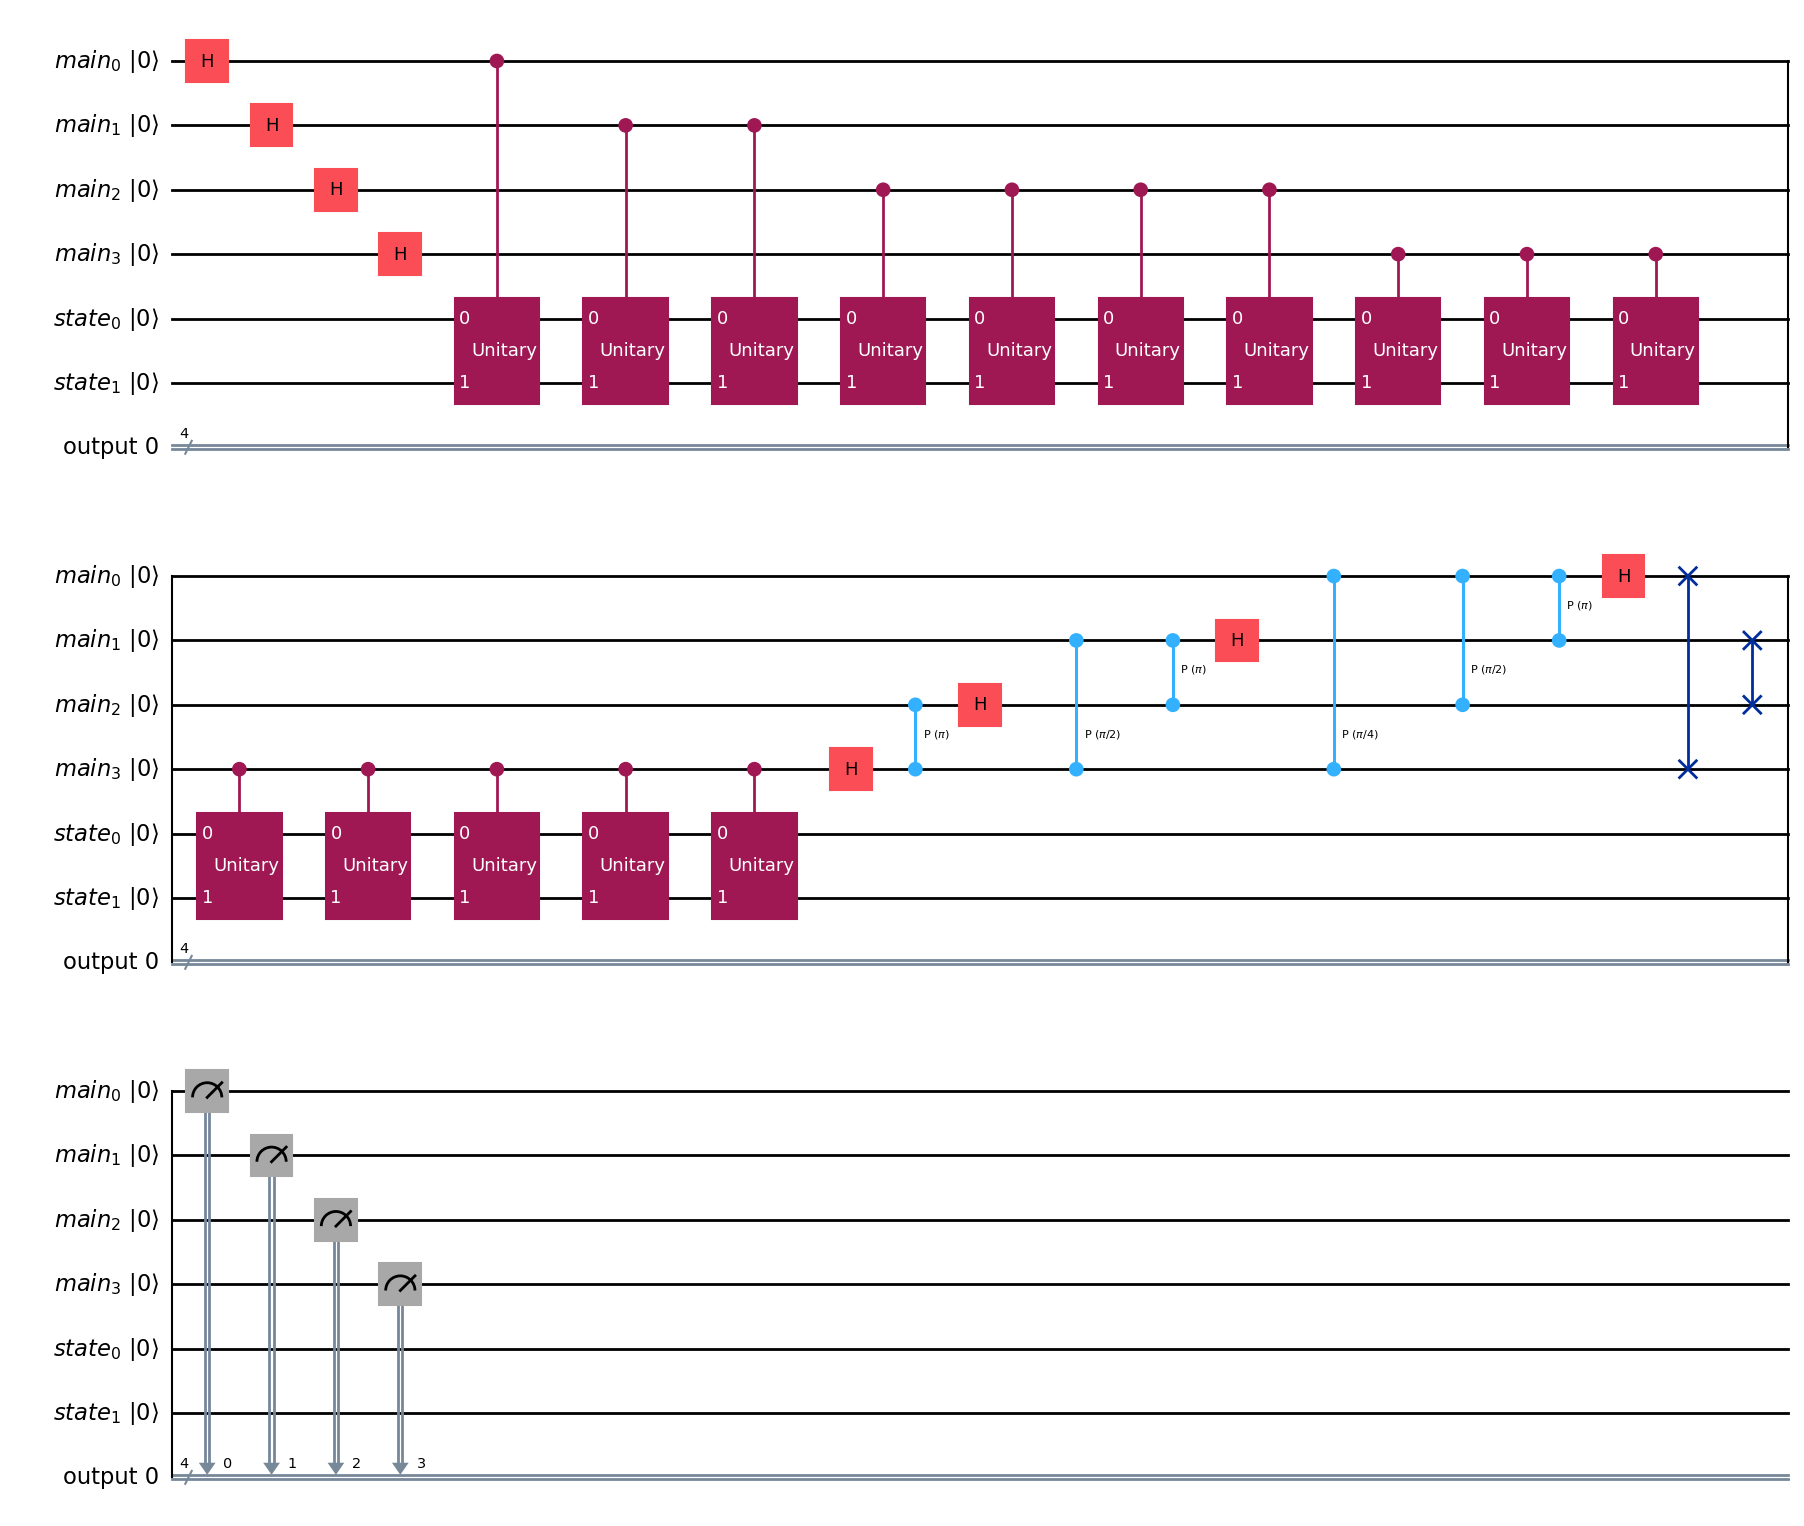

In [14]:
circuit.draw(justify = "none", initial_state=True, output="mpl")

### 7. Simulating
    We now run this code in the Quantum Aer Simulator

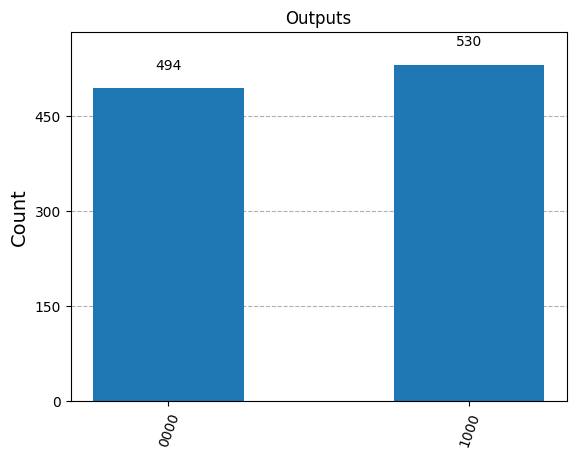

In [15]:
counts_ideal=histogram(circuit)
plot_histogram(counts_ideal, title='Outputs')

In [16]:
eigenvalues = {}
for key in counts_ideal:
    eigenvalues.update([(np.e**(2j*np.pi*(int(key,2)/(2**m))),counts_ideal[key])])
print(eigenvalues)

{(-1+1.2246467991473532e-16j): 530, (1+0j): 494}
